## Задание.
На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
from scipy import stats
from scipy.stats import shapiro

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

import statsmodels as sm
from statsmodels.stats.power import TTestIndPower

Подготовка данных

In [53]:
df = pd.read_excel('gb_sem_8_hm.xlsx')
df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [54]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [55]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [56]:
df.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [57]:
df.USER_ID.nunique()

6324

In [58]:
df = df.groupby(['USER_ID', 'VARIANT_NAME'], as_index=False).agg({'REVENUE': 'sum'})

In [59]:
df.shape

(7865, 3)

In [60]:
df.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': 'count'})['VARIANT_NAME'].value_counts()

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

Избавимся от некорретных строк. Посчитаем, сколько типов встречается у каждого пользователя.

In [61]:
unique_ids = \
(df
 .groupby('USER_ID', as_index=False)
 .agg({'VARIANT_NAME': 'count'})
 .query('VARIANT_NAME == 1')
 .USER_ID
 .values
 )

In [62]:
df_new = df[df.USER_ID.isin(unique_ids)].copy(deep=True)

In [63]:
df_new.shape

(4783, 3)

In [64]:
df_new.describe()

,USER_ID,REVENUE
count,4783.000000,4783.000000
mean,4994.395777,0.135873
std,2898.618472,3.011392
min,2.000000,0.000000
25%,2476.000000,0.000000
50%,4975.000000,0.000000
75%,7515.000000,0.000000
max,9998.000000,196.010000


In [65]:
control = df_new.query('VARIANT_NAME == "control"')

test = df_new.query('VARIANT_NAME == "variant"')

*Проверка на нормальность*

In [66]:
alpha = 0.05
st = shapiro(df.REVENUE)
print('Discription is {}normal\n'.format( {True: 'not ',False: ''}[st[1] < alpha]))

Discription is not normal



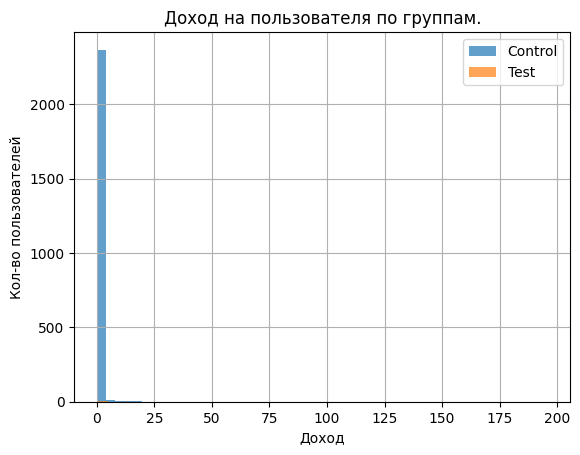

In [67]:
control.REVENUE.hist(bins = 50, alpha = 0.7, label = 'Control')
test.REVENUE.hist(bins = 50, alpha = 0.7, label = 'Test')
plt.title('Доход на пользователя по группам.')
plt.xlabel('Доход')
plt.ylabel('Кол-во пользователей')
plt.legend()

In [68]:
mw_stats = scipy.stats.mannwhitneyu(x=control.REVENUE.values, y = test.REVENUE.values)

mw_stats

MannwhitneyuResult(statistic=2874161.0, pvalue=0.2104875008271777)

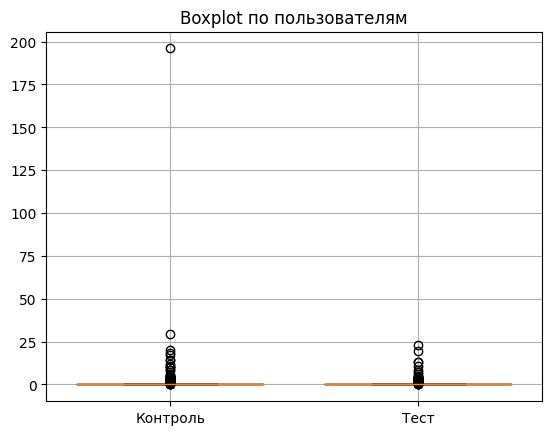

In [69]:
plt.boxplot([control.REVENUE, test.REVENUE],
            labels = ['Контроль', 'Тест'],
            widths = 0.75
            )
plt.title('Boxplot по пользователям', loc='center')
plt.grid(axis='both')

In [70]:
stats.ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=1.3996978409515475, pvalue=0.16172355638776942)

*Расчёт мощности теста*

In [71]:
C_mean = control.REVENUE.values.mean()
T_mean = test.REVENUE.values.mean()

C_std = control.REVENUE.values.std()
T_std = test.REVENUE.values.std()

print(len(control.REVENUE.values), len(test.REVENUE.values))

2390 2393


In [72]:
n = len(control.REVENUE.values)
     
S = np.sqrt((T_std**2 +C_std**2)/2)
     
ef = float((C_mean-T_mean)/S)

In [73]:
alpha = 0.05
analysis = TTestIndPower()
analysis = sm.stats.power.TTestIndPower()
result = analysis.solve_power(ef, power=None,
                              nobs1=n, ratio=1.0, alpha=alpha)

result

0.2880309627335733

# Ответ:
Статистически разница между группами незначительна. Не применять изменения или провести тест повторно с проверкой на корректность.